# Libraries

In [1]:
library(dagitty)
library(tidyverse)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Question

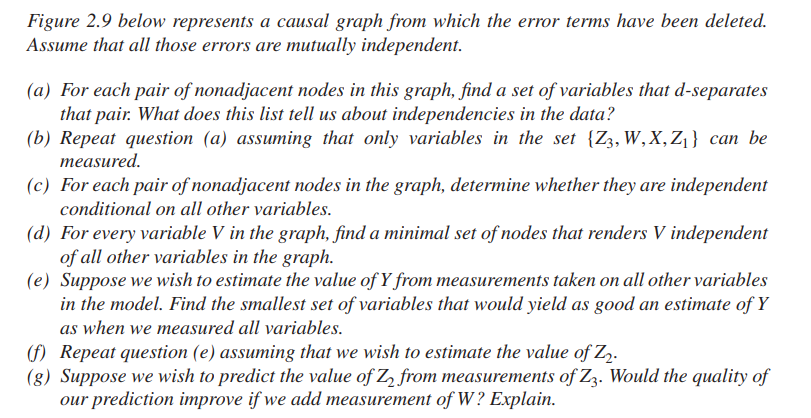

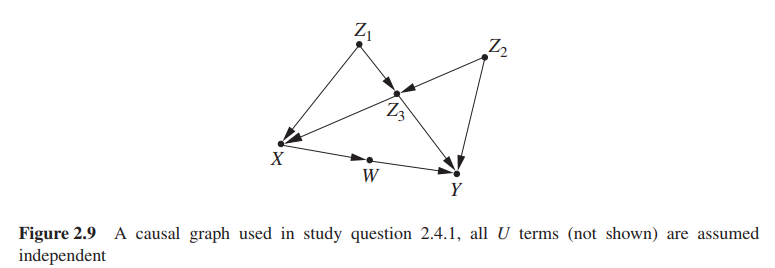

# Solution

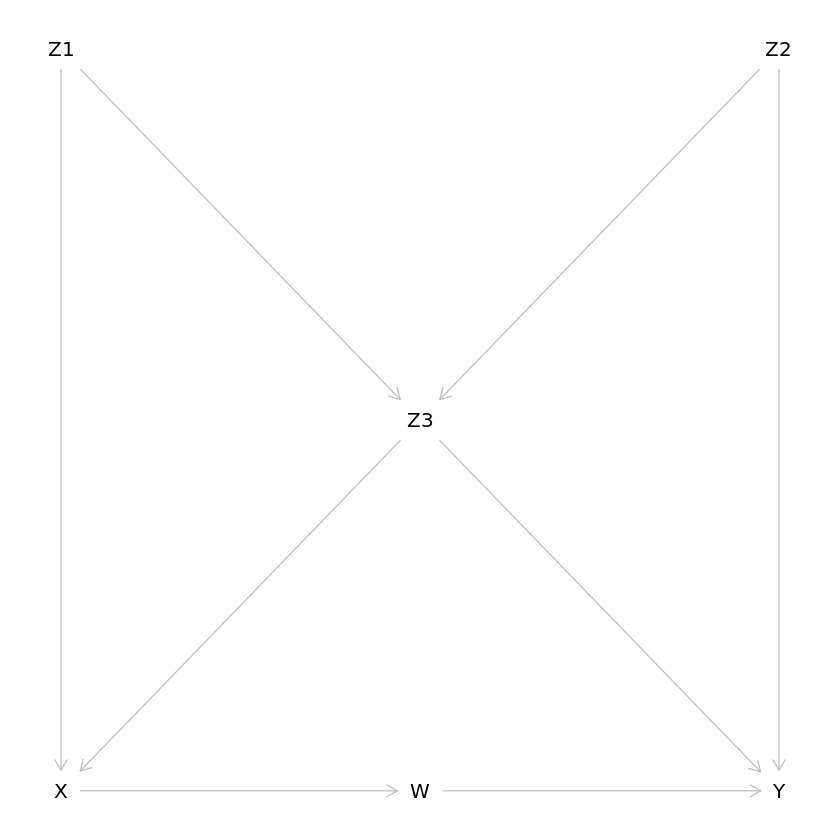

In [2]:
g <- dagitty('dag {
    Z1 -> X
    Z1 -> Z3
    Z2 -> Z3
    Z2 -> Y
    Z3 -> X
    Z3 -> Y
    X -> W
    W -> Y
}')

coordinates(g) <- list(x=c(X=1,W=2,Y=3,Z1=1,Z3=2,Z2=3),
    y=c(X=0,W=0,Y=0,Z2=-2,Z1=-2,Z3=-1))
plot(g)

# Solution

## (a)

In [3]:
impliedConditionalIndependencies(g)

W _||_ Z1 | X
W _||_ Z2 | Z1, Z3
W _||_ Z2 | X
W _||_ Z3 | X
X _||_ Y | W, Z2, Z3
X _||_ Y | W, Z1, Z3
X _||_ Z2 | Z1, Z3
Y _||_ Z1 | X, Z2, Z3
Y _||_ Z1 | W, Z2, Z3
Z1 _||_ Z2

### (b)

View current variables that are unobserved:

In [4]:
latents(g)

list()

Set the latent variables according to the question:

In [5]:
new_latent_vars <- setdiff(names(g), c("Z3", "W", "X", "Z1"))
latents(g) <- new_latent_vars

latents(g)

[1] "Y"  "Z2"

Find the conditional independencies given the latent variables:

In [6]:
impliedConditionalIndependencies(g)

W _||_ Z1 | X
W _||_ Z3 | X

## (c)

In [7]:
is_adjacent <- function(from, to){    
    paths(g, from, to) %>%
    pluck("paths") %>%
    str_split("->|<-") %>%
    map(length) %>%
    some(~.x == 2)
}

other_variables <- function(from, to){
    setdiff(names(g), c(from, to))
}

display_results <- function(pairs, i){
    from <- pairs[1]
    to <- pairs[2]
    other_vars <- other_variables(from, to) %>%
        paste(collapse = ", ")
    
    str_interp("${from}, ${to} is independent given ${other_vars}")
}

In [8]:
pairs <- combn(names(g), 2) %>%
    array_branch(2) %>%
    keep(~!is_adjacent(.x[1], .x[2]))

pairs

[[1]]
[1] "W"  "Z1"

[[2]]
[1] "W"  "Z2"

[[3]]
[1] "W"  "Z3"

[[4]]
[1] "X" "Y"

[[5]]
[1] "X"  "Z2"

[[6]]
[1] "Y"  "Z1"

[[7]]
[1] "Z1" "Z2"

In [9]:
pairs %>%
    keep(~dseparated(g, .x[1], .x[2], other_variables(.x[1], .x[2]))) %>%
    iwalk(~message(display_results(.x, .y)))

W, Z1 is independent given X, Y, Z2, Z3

X, Y is independent given W, Z1, Z2, Z3

X, Z2 is independent given W, Y, Z1, Z3

Y, Z1 is independent given W, X, Z2, Z3



## (d)

This is the same as finding the [markov blanket](https://en.wikipedia.org/wiki/Markov_blanket) of a node, V:

In [10]:
markovBlanket(g, "X")

[1] "Z1" "Z3" "W"

In [11]:
v <- names(g)


v %>%
    map(function(x) {message(x); markovBlanket(g, x)})

W

X

Y



ERROR: Error in if (!(v %in% names(x))) stop(paste(v, "is not a variable in `x`")): argument is of length zero


### (e)

This means finding all the variables that are dependent on Y:

In [12]:
all_vars <- names(g)
target_var <- "Y"

all_predictors <- setdiff(all_vars, target_var)

# variables that are independent of Y given all other variables
independent_vars <- dseparated(g, target_var, list(), all_predictors) %>%
    keep(~ !.x == "Y")

independent_vars %>%
    walk(~ message(str_interp("Y is independent of ${.x} given ${paste(all_predictors, collapse = ', ')}")))

dependent_vars <- setdiff(all_predictors, independent_vars)

message(str_interp("The smallest set of variables that would yield a good estimate of Y is ${paste(dependent_vars, collapse =', ')}"))

Y is independent of X given W, X, Z1, Z2, Z3

Y is independent of Z1 given W, X, Z1, Z2, Z3

The smallest set of variables that would yield a good estimate of Y is W, Z2, Z3



This is also the same as finding the markov blanket of Y:

In [13]:
markovBlanket(g, "Y")

ERROR: Error in if (!(v %in% names(x))) stop(paste(v, "is not a variable in `x`")): argument is of length zero


## (f)

In [14]:
all_vars <- names(g)
target_var <- "Z2"

all_predictors <- setdiff(all_vars, target_var)

independent_vars <- dseparated(g, target_var, list(), all_predictors) %>%
    keep(~ !.x == target_var)

independent_vars %>%
    walk(~ message(str_interp("${target_var} is independent of ${.x} given ${paste(all_predictors, collapse = ', ')}")))

dependent_vars <- setdiff(all_predictors, independent_vars)

message(str_interp("The smallest set of variables that would yield a good estimate of ${target_var} is ${paste(dependent_vars, collapse =', ')}"))

Z2 is independent of X given W, X, Y, Z1, Z3

The smallest set of variables that would yield a good estimate of Z2 is W, Y, Z1, Z3



### (g)

In [15]:
dseparated(g, "Z2", "W", "Z3")

[1] FALSE

Since $Z_2$ is **not independent** of $W$ given $Z_3$, adding $W$ will improve our estimate of $Z_2$.